In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from koopman.simulation.animation import PlotEnvironment
from koopman.simulation.systems import DynamicalSystem, Pendulum
from IPython.display import HTML

In [2]:
A = np.array([[ 1.00000036e+00,  4.99989972e-02, -1.22630372e-02,
         5.73729317e-08, -2.02405229e-04,  2.54901813e-06,
         2.53553406e-05],
       [ 4.24999056e-05,  9.99891849e-01, -4.90537847e-01,
         6.71898738e-06, -1.20231391e-02,  2.01319270e-04,
         2.00847963e-03],
       [-3.44137539e-04,  8.74112909e-04,  1.00021231e+00,
        -5.39396238e-05,  4.80568204e-02, -1.21582942e-03,
        -1.22468222e-02],
       [ 3.53013819e-05, -7.25291556e-05,  1.14653223e-03,
         9.90487381e-01,  1.38300367e-04, -4.90075216e-05,
        -8.39543712e-05],
       [-2.01399086e-02,  5.12311211e-02, -1.01230312e-03,
        -3.09040242e-03,  8.85143841e-01, -4.68438099e-02,
        -4.80665294e-01],
       [ 7.35181349e-01, -1.84835962e+00,  1.10041353e+00,
         1.05683858e-01,  4.18816647e+00,  7.78549157e-01,
        -3.20071962e-01],
       [ 2.22198524e-03, -8.57630036e-03,  7.10691577e-03,
         1.73321898e-04,  2.20312875e-02, -3.30327084e-04,
         9.30150720e-01]])

B = np.array([[ 1.25037881e-03],
       [ 5.00467861e-02],
       [-3.76119985e-04],
       [ 1.96016822e-04],
       [-2.13330785e-02],
       [ 6.24373836e-01],
       [ 1.37656442e-02]])

Cs = np.concatenate(np.array([[[-4.98419193e-09,  1.18103548e-08, -3.27826925e-08,
         -2.29168529e-06, -2.81149734e-08,  1.11479860e-09,
         -1.47550904e-08],
        [-5.59729370e-07,  1.33438825e-06, -5.31018531e-06,
         -1.77579610e-04, -3.25728945e-06,  1.77817203e-07,
         -1.47091110e-06],
        [ 4.43512415e-06, -1.05629187e-05,  4.93099227e-05,
          1.02199487e-03,  2.60810313e-05, -1.63458768e-06,
          1.02688009e-05],
        [ 7.46616499e-04, -1.25342096e-03, -3.71899117e-02,
         -1.18350936e-05, -3.27932608e-03, -5.93675756e-04,
          2.40717935e-02],
        [ 2.43862343e-04, -5.85605730e-04,  3.60006180e-03,
          3.50346393e-02,  1.48317265e-03, -1.17922634e-04,
          4.59750516e-04],
        [-7.42236795e-03,  1.85915248e-02, -1.92217233e-01,
          9.38024195e-01, -5.04750932e-02,  6.10806260e-03,
         -3.20668878e-03],
        [ 1.46530266e-06, -1.47167262e-05,  3.24991122e-04,
         -2.85499450e-02, -3.92602739e-06, -3.50560266e-06,
         -4.92623164e-04]]]), axis=0)

def koopman_observables(xhist: np.ndarray) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)

    theta, omega = xhist[:, 0], xhist[:, 1]

    Y = np.column_stack([
        np.sin(theta),
        np.cos(theta),
        np.cos(theta) * omega,
        np.sin(theta) * omega**2,
        np.cos(theta) * np.sin(theta),
    ])
    
    out = np.concatenate([
        xhist, Y
    ], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

In [3]:
# Constants
g = 9.81      # gravity
l = 1.0       # length
m = 1.0       # mass
dt = 0.02     # timestep
tf = 10.0
N = int(tf / dt)  # number of timesteps
nx = 2
nz = A.shape[0]
nu = B.shape[1]

P = np.block([
    np.eye(nx), np.zeros((nx, nz - nx)),
])

# Cost matrices
Q = np.diag([1.0, 0.1])        # State cost
R = np.diag([0.01])            # Control cost
Qf = 100 * Q                   # Terminal cost

theta0, omega0 = 0.01, 0.0
thetaf, omegaf = np.pi, 0.0

x0_val = np.array([theta0, omega0])
z0_val = koopman_observables(x0_val)

xf_val = np.array([thetaf, omegaf])

# A = np.zeros((nz, nz))
# B = np.zeros((nz, nu))
# Cs = np.zeros((nz, nu * nz))

def discrete_dynamics(z, u):
    z_next = A @ z + B @ u + Cs @ ca.kron(u, z)
    return z_next

In [4]:
Z = ca.MX.sym('Z', nz, N + 1)
U = ca.MX.sym('U', nu, N)

cost = 0
ineq = []

for k in range(N):
    zk = Z[:, k]
    uk = U[:, k]
    zk_next = Z[:, k+1]

    # Stage cost
    xkerr = P @ zk - xf_val
    
    cost += ca.mtimes([xkerr.T, Q, xkerr])
    cost += ca.mtimes([uk.T, R, uk])

    # Dynamics constraint
    zk_next_pred = discrete_dynamics(zk, uk)
    ineq.append(zk_next_pred - zk_next)

# Terminal cost
xNerr = P @ Z[:, N] - xf_val
cost += ca.mtimes([xNerr.T, Qf, xNerr])

# Initial condition constraint
ineq.insert(0, Z[:, 0] - z0_val)

ineq_flat = ca.vertcat(*ineq)

# Define decision variables
opt_vars = ca.vertcat(
    ca.reshape(Z, nz * (N + 1), 1),
    ca.reshape(U, nu * N, 1)
)

In [5]:
# Create NLP
nlp = {'x': opt_vars, 'f': cost, 'g': ineq_flat}

# Solver
solver = ca.nlpsol('solver', 'ipopt', {'x': opt_vars, 'f': cost, 'g': ineq_flat},
                   {'ipopt.print_level': 0, 'print_time': 0})

# Initial guess
z0_guess = np.tile(np.zeros((nz, 1)), (N+1, 1))
u0_guess = np.random.randn(nu, N)
x0u0 = np.concatenate([z0_guess.flatten(), u0_guess.flatten()])

lbg = ubg = np.zeros(ineq_flat.shape)

z_min = -ca.inf * np.ones((nz, N + 1))
z_max = ca.inf * np.ones((nz, N + 1))
u_min = -2.0 * np.ones((nu, N))
u_max = 2.0 * np.ones((nu, N))

lbx = np.concatenate([z_min.flatten(), u_min.flatten()])
ubx = np.concatenate([z_max.flatten(), u_max.flatten()])

sol = solver(x0=x0u0, lbg=lbg, ubg=ubg, lbx=lbx, ubx=ubx)

stats = solver.stats()
print(f"Solver statistics:")
print(f"\titer_count: {stats['iter_count']}")
print(f"\treturn_status: {stats['return_status']}")

for k in stats:
    if k.startswith('t_'):
        print(f"\t{k}: {stats[k]}")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solver statistics:
	iter_count: 34
	return_status: Solve_Succeeded
	t_proc_callback_fun: 0.0
	t_proc_nlp_f: 0.005809999999999999
	t_proc_nlp_g: 0.007693
	t_proc_nlp_grad: 0.0
	t_proc_nlp_grad_f: 0.009728999999999998
	t_proc_nlp_hess_l: 0.07893599999999999
	t_proc_nlp_jac_g: 0.04774599999999998
	t_wall_callback_fun: 0.0
	t_wall_nlp_f: 0.005723987999999999
	t_wall_nlp_g: 0.0076283969999999994
	t_wall_nlp_grad: 0.0
	t_wall_nlp_grad_f: 0.009752342
	t_wall_nlp_hess_l: 0.07660657199999998
	t_wall_nlp_jac_g: 0.04719861799999999


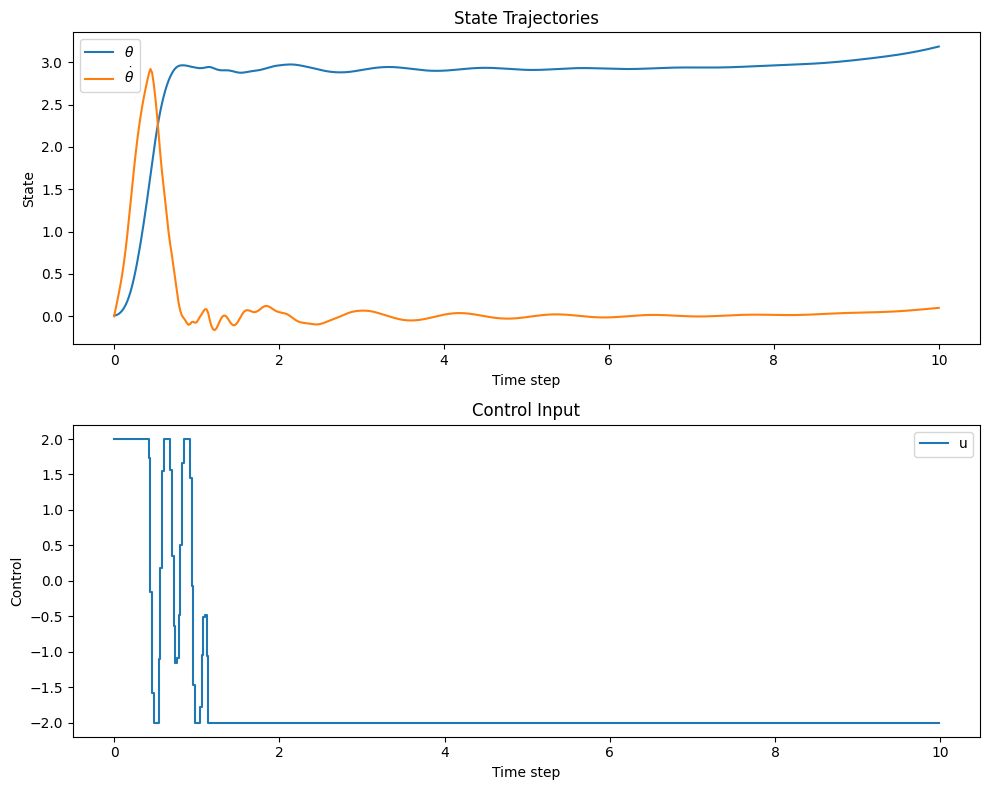

In [6]:
opt = sol['x'].full().flatten()
Z_opt = opt[:nz*(N+1)].reshape((N+1, nz))
X_opt = Z_opt @ P.T
U_opt = opt[nz*(N+1):].reshape((N, nu))

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ts = np.arange(0, tf + dt, dt)

ax[0].plot(ts, X_opt[:, 0], label=r'$\theta$')
ax[0].plot(ts, X_opt[:, 1], label=r'$\dot{\theta}$')
ax[0].set_title('State Trajectories')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('State')
ax[0].legend()

ax[1].step(ts[:-1], U_opt[:, 0], label='u', where='post')
ax[1].set_title('Control Input')
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Control')
ax[1].legend()

plt.tight_layout()
plt.show()

In [9]:
np.set_printoptions(threshold=np.inf)

print(
    repr(X_opt)
)

array([[ 1.00000000e-02,  2.59119320e-32],
       [ 1.23738596e-02,  9.48602151e-02],
       [ 1.94805913e-02,  1.89527176e-01],
       [ 3.13679756e-02,  2.86759391e-01],
       [ 4.82794817e-02,  3.91383152e-01],
       [ 7.07189925e-02,  5.08717444e-01],
       [ 9.94356687e-02,  6.43016412e-01],
       [ 1.35338619e-01,  7.96268195e-01],
       [ 1.79365529e-01,  9.67581178e-01],
       [ 2.32337346e-01,  1.15324095e+00],
       [ 2.94831431e-01,  1.34736890e+00],
       [ 3.67098859e-01,  1.54298997e+00],
       [ 4.49039910e-01,  1.73324615e+00],
       [ 5.40238160e-01,  1.91248497e+00],
       [ 6.40041134e-01,  2.07700360e+00],
       [ 7.47666713e-01,  2.22532341e+00],
       [ 8.62311031e-01,  2.35798231e+00],
       [ 9.83235671e-01,  2.47693689e+00],
       [ 1.10981861e+00,  2.58474206e+00],
       [ 1.24156273e+00,  2.68370808e+00],
       [ 1.37806562e+00,  2.77522098e+00],
       [ 1.51896235e+00,  2.85936002e+00],
       [ 1.66352200e+00,  2.92143433e+00],
       [ 1.